In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#Question 1. True trajectory
T = 2
N = 500
#Initial state vector
X_true_0 = np.array([[1000], [100], [1000], [100]])
#State vector
X_true = np.zeros((4, N))
#Transition matrix
Phi = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
#Input matrix
G = np.array([[T**2 / 2, 0], [T, 0], [0, T**2 / 2], [0, T]])
#True noise
sigma_a_1 = 0.3 ** 2

#Observation matrix
#H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

def true_trajectory_(X_0_1, sigma_a, N):
    X_0_ = np.zeros((4, N))
    D_ = np.zeros((N, 1))
    betta_ = np.zeros((N, 1))
    a_i = np.zeros((2, 1))
    
    a_i[0, 0] = np.random.normal(0, np.sqrt(sigma_a))
    a_i[1, 0] = np.random.normal(0, np.sqrt(sigma_a))
    X_0_[:, 0] = (Phi.dot(X_0_1) + G.dot(a_i)).reshape(-1)
    for n in range (1, N):
        a_i[0, 0] = np.random.normal(0, np.sqrt(sigma_a))
        a_i[1, 0] = np.random.normal(0, np.sqrt(sigma_a))

        X_0_[:, n] = (Phi.dot(X_0_[:, n-1].reshape(4, 1)) + G.dot(a_i)).reshape(-1)
    
    D_ = np.sqrt(X_0_[0, :] ** 2 + X_0_[2, :] ** 2)
    betta_= np.arctan(X_0_[0, :]/X_0_[2, :])
    return X_0_, D_, betta_

X_true, D_true, betta_true = true_trajectory_(X_true_0, sigma_a_1, N)


In [3]:
#Measurments 1
sigma_D = 50**2
sigma_betta_1 = 0.004**2

def measurements_1(D_in, betta_in, sigma_D, sigma_betta, N):
    Z_m = np.zeros((2, N))
    for n in range(0, N-1, 2):
        Z_m[0, n] = D_in[n] + np.random.normal(0, np.sqrt(sigma_D))      
        Z_m[1, n] = betta_in[n] + np.random.normal(0, np.sqrt(sigma_betta))
 
    return Z_m

zm_1 = measurements_1(D_true, betta_true, sigma_D, sigma_betta_1, N)

In [4]:
#Measurments 2
sigma_betta_2 = 0.001**2

def measurements_2(betta_in, sigma_betta, N):
    Z_m = np.zeros(N)

    for n in range(3, N, 2):
        Z_m[n] = betta_in[n] + np.random.normal(0, np.sqrt(sigma_betta))
 
    return Z_m

zm_2 = measurements_2(betta_true, sigma_betta_2, N)

In [5]:
#Kalman

X_0 = np.array([[zm_1[0, 2]*np.sin(zm_1[1, 2])], [(zm_1[0, 2]*np.sin(zm_1[1, 2]) - zm_1[0, 0]*np.sin(zm_1[1, 0])) / (2*T)], 
                [zm_1[0, 2]*np.cos(zm_1[1, 2])], [(zm_1[0, 2]*np.cos(zm_1[1, 2]) - zm_1[0, 0]*np.cos(zm_1[1, 0])) / (2*T)]])
P_0 = np.eye(4)*(10**4)

Q = G.dot(G.T) * sigma_a_1
R_1 = np.array([[sigma_D, 0], [0, sigma_betta_1]])
R_2 = sigma_betta_2


def Kalman(X_init, P_init, size_, z_1, z_2):
    #Filterd position
    X_pred = np.zeros((4, size_))
    P_pred = np.zeros((4, 4, size_))

    X_filt = np.zeros((4, size_))
    P_filt = np.zeros((4, 4, size_))

    dh_1 = np.zeros((2, 4, size_)) 
    dh_2 = np.zeros((1, 4, size_)) 

    K_1 = np.zeros((4, 2, size_))
    K_2 = np.zeros((4, 1, size_))

    X_filt[:, 3] = X_init[:, 0]
    P_filt[:, :, 3] = P_init
    D_betta_out = np.zeros((4, size_-4))

    #Covariance matrix 𝑅 of measurements noise
    R_1 = np.array([[sigma_D, 0], [0, sigma_betta_1]])
    R_2 = sigma_betta_2
    I = np.eye(4)

    for n in range(4, size_):

        X_pred[:, n] = (Phi.dot(X_filt[:, n-1].reshape(4, 1))).reshape(-1)
        P_pred[:, :, n] = (Phi.dot(P_filt[:, :, n-1])).dot(Phi.T) + Q

        if n % 2 == 0: 
            dh_1[:,:,n] = np.array([[X_pred[0, n] / np.sqrt(X_pred[0, n]**2 + X_pred[2, n]**2), 0, X_pred[2, n] / np.sqrt(X_pred[0, n]**2 + X_pred[2, n]**2), 0], [X_pred[2, n] / (X_pred[0, n]**2 + X_pred[2, n]**2), 0, -X_pred[0, n]/(X_pred[0, n]**2 + X_pred[2, n]**2), 0]])              
            
            D = np.sqrt(X_pred[0, n]**2 + X_pred[2, n]**2)
            bet = np.arctan(X_pred[0, n]/X_pred[2, n])
            h = np.array([D, bet]) 

            K_1[:, :, n] = P_pred[:, :, n].dot(dh_1[:, :, n].T).dot(np.linalg.inv(dh_1[:, :, n].dot(P_pred[:, :, n]).dot(dh_1[:, :, n].T) + R_1))
            P_filt[:, :, n] = (I - K_1[:, :, n].dot(dh_1[:, :, n])).dot(P_pred[:, :, n])
            X_filt[:, n] = (X_pred[:, n].reshape(4, 1) + K_1[:, :, n].dot(z_1[:, n].reshape(2, 1) - h.reshape(2, 1))).reshape(-1)

        else:
            dh_2[0, 0, n] = X_pred[2, n] / (X_pred[0, n]**2 + X_pred[2, n]**2)
            dh_2[0, 2, n] = -X_pred[0, n] / (X_pred[0, n]**2 + X_pred[2, n]**2)
            
            bet = np.arctan(X_pred[0, n]/X_pred[2, n])
            h = np.array([bet]) 

            K_2[:, :, n] = P_pred[:, :, n].dot(dh_2[:, :, n].T) / (dh_2[:, :, n].dot(P_pred[:, :, n]).dot(dh_2[:, :, n].T) + R_2)
            P_filt[:, :, n] = (I - K_2[:, :, n].dot(dh_2[:, :, n])).dot(P_pred[:, :, n])
            X_filt[:, n] = (X_pred[:, n].reshape(4, 1) + K_2[:, :, n]*(z_2[n] - h)).reshape(-1)
        D_betta_out[0, n-4] = np.sqrt(X_pred[0, n] ** 2 + X_pred[2, n] ** 2) #D predicted
        D_betta_out[1, n-4]= np.arctan2(X_pred[0, n],  X_pred[2, n]) #Betta predicted
        D_betta_out[2, n-4] = np.sqrt(X_filt[0, n] ** 2 + X_filt[2, n] ** 2) #D filtered
        D_betta_out[3, n-4]= np.arctan2(X_filt[0, n], X_filt[2, n]) #Betta filtered

    return X_pred, X_filt, D_betta_out


In [6]:
X_pred_1, X_filt_1, D_betta1 = Kalman(X_0, P_0, N, zm_1, zm_2)

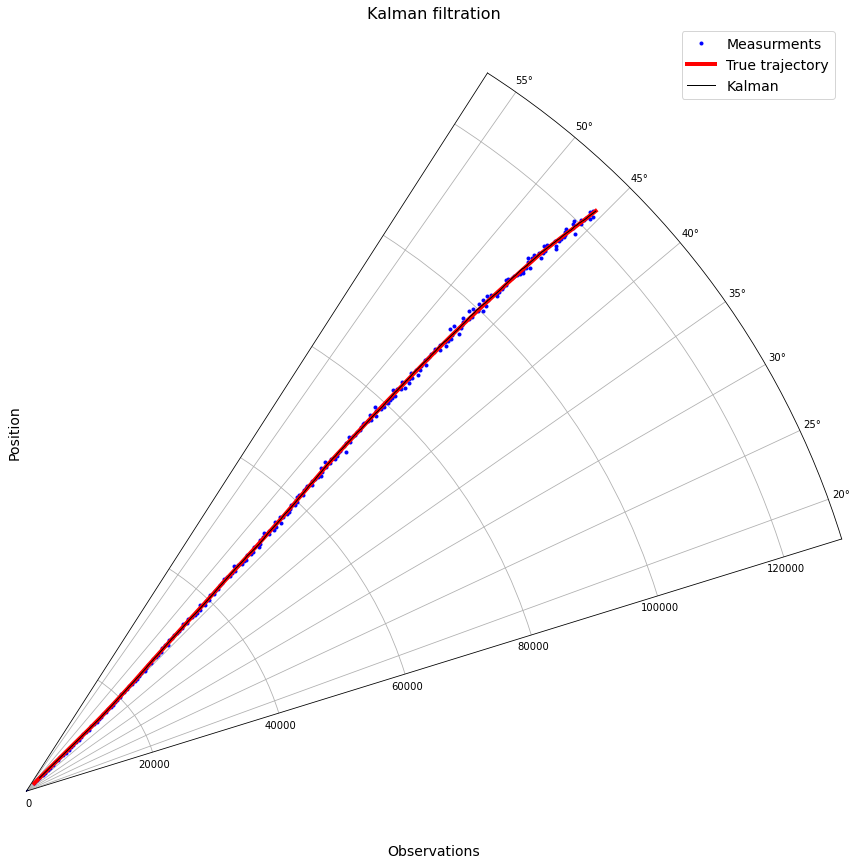

In [16]:
fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'projection': 'polar'})
ax.set_title("Kalman filtration", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
ax.set_title("Kalman filtration", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
ax.plot(zm_1[1, :], zm_1[0, :], '.b',linewidth=1,  label = "Measurments")
ax.plot(betta_true, D_true, linewidth=4, label = "True trajectory", c = 'r')
ax.plot(D_betta1[3, :], D_betta1[2, :], linewidth=1, label = "Kalman", c = 'k')

plt.xlim(0.3, 1)
plt.legend(fontsize = 14,loc = 'best')


In [8]:
def Errors(n, M):
    error_pred = np.zeros((2, n-4, M))
    error_filt = np.zeros((2, n-4, M))
    error_meas = np.zeros((3, n, M))
    
    for i in range(M):
        X_true_, D_true_, betta_true_ = true_trajectory_(X_true_0, sigma_a_1, N)
        zm_1 = measurements_1(D_true_, betta_true_, sigma_D, sigma_betta_1, N)
        zm_2 = measurements_2(betta_true, sigma_betta_2, N)

        X_pred, X_filt, D_betta = Kalman(X_0, P_0, N, zm_1, zm_2)
        
        error_pred[0, :, i] = (D_true_[4:] - D_betta[0, :]) ** 2
        error_pred[1, :, i] = (betta_true_[4:] - D_betta[1, :]) ** 2
        error_filt[0, :, i] = (D_true_[4:] - D_betta[2, :]) ** 2
        error_filt[1, :, i] = (betta_true_[4:] - D_betta[3, :]) ** 2
        
        error_meas[0, :, i] = (D_true_ - zm_1[0, :]) ** 2
        error_meas[1, :, i] = (betta_true_ - zm_1[1, :]) ** 2
        error_meas[2, :, i] = (betta_true_ - zm_2) ** 2

    Final_err_pred = np.sqrt(np.sum(error_pred, axis = 2) / (M - 1))
    Final_err_filt = np.sqrt(np.sum(error_filt, axis = 2) / (M - 1))
    Final_err_meas = np.sqrt(np.sum(error_meas, axis = 2) / (M - 1))
    
    return Final_err_pred, Final_err_filt, Final_err_meas

Final_err_pred, Final_err_filt, Final_err_meas = Errors(N, 500)

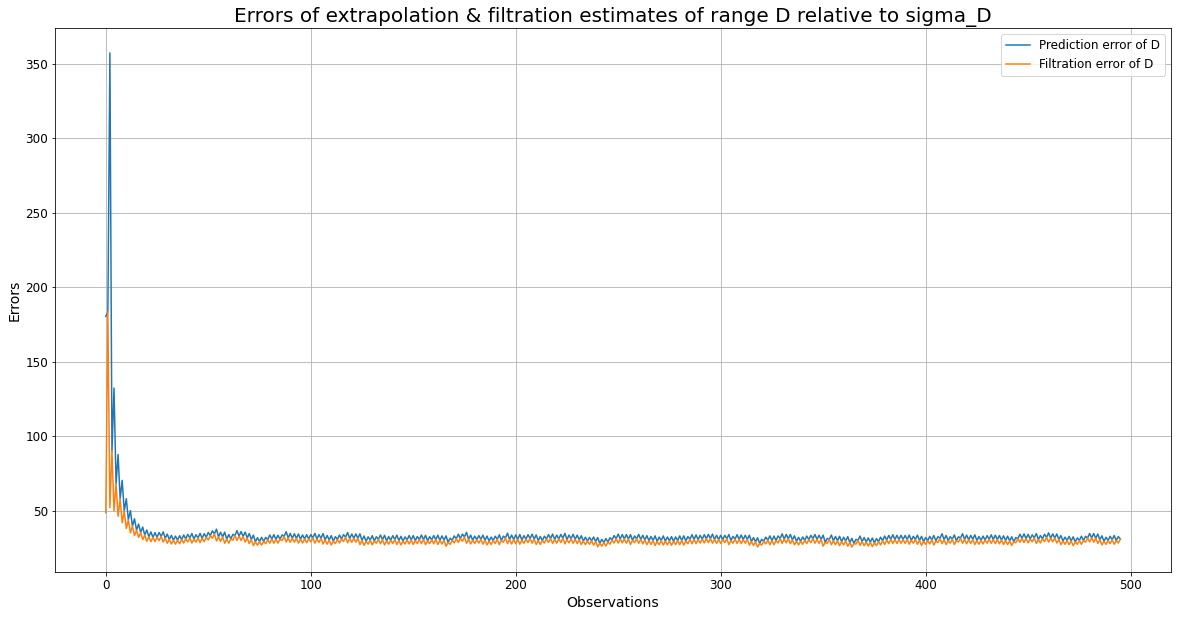

In [9]:
fig, x = plt.subplots(figsize=(20,10))
x.set_title("Errors of extrapolation & filtration estimates of range D relative to sigma_D", fontsize = 20)
x.set_xlabel("Observations", fontsize = 14)
x.set_ylabel("Errors", fontsize = 14)
x.plot(Final_err_pred[0, :], label = "Prediction error of D")
x.plot(Final_err_filt[0, :], label = "Filtration error of D")
x.tick_params(labelsize = 12)
x.legend(fontsize = 12)
x.grid()

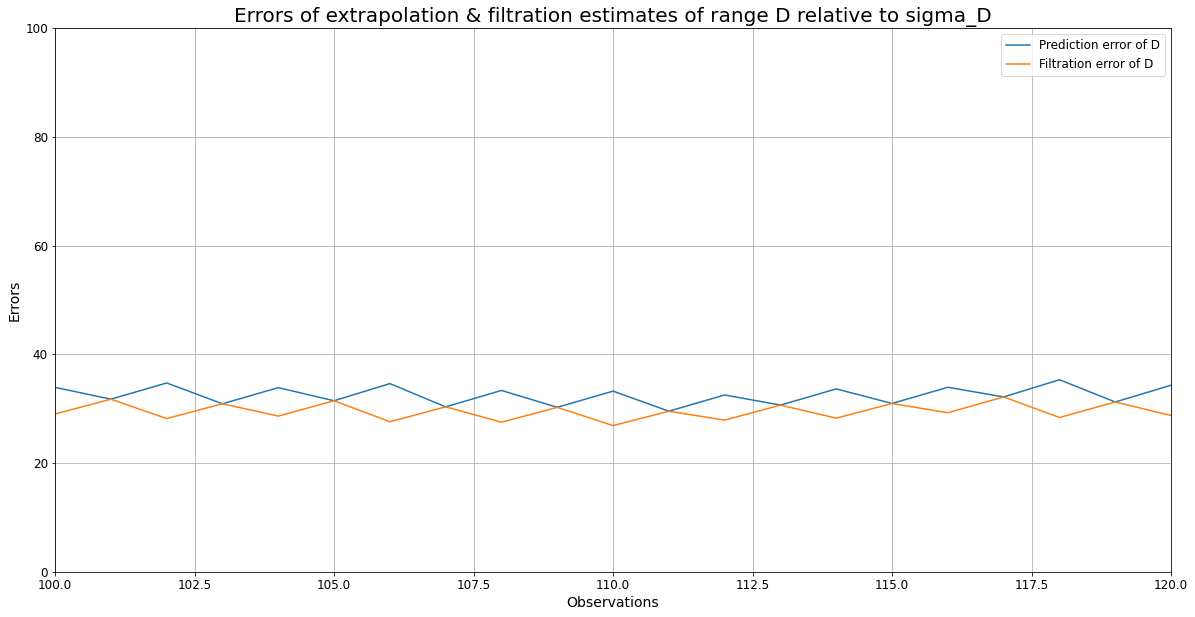

In [10]:
fig, x = plt.subplots(figsize=(20,10))
x.set_title("Errors of extrapolation & filtration estimates of range D relative to sigma_D", fontsize = 20)
x.set_xlabel("Observations", fontsize = 14)
x.set_ylabel("Errors", fontsize = 14)
x.plot(Final_err_pred[0, :], label = "Prediction error of D")
x.plot(Final_err_filt[0, :], label = "Filtration error of D")
x.tick_params(labelsize = 12)
x.legend(fontsize = 12)
plt.xlim(100, 120)
plt.ylim(0, 100)

x.grid()

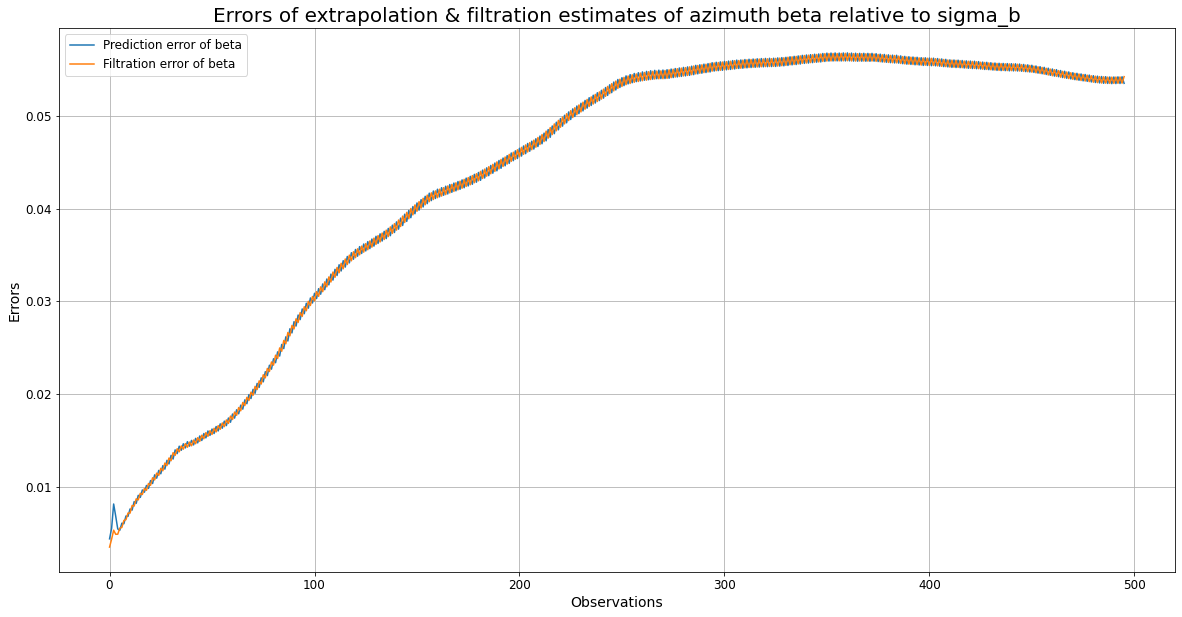

In [11]:
fig, b = plt.subplots(figsize=(20,10))
b.set_title("Errors of extrapolation & filtration estimates of azimuth beta relative to sigma_b", fontsize = 20)
b.set_xlabel("Observations", fontsize = 14)
b.set_ylabel("Errors", fontsize = 14)
b.plot(Final_err_pred[1, :], label = "Prediction error of beta")
b.plot(Final_err_filt[1, :], label = "Filtration error of beta")
b.tick_params(labelsize = 12)
b.legend(fontsize = 12)
b.grid()